In [116]:
import tensorflow as tf
import tensorflow_quantum as tfq

from tensorflow.keras import datasets, layers, models

import cirq
import sympy
import numpy as np
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


In [117]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [118]:
x_train= tf.cast(x_train, tf.float32)
x_test=tf.cast(x_test, tf.float32)

x_train = tf.image.resize(x_train[:10000], (7,7)).numpy()
x_test = tf.image.resize(x_test[:1000], (7,7)).numpy()

y_train = y_train[:10000]
y_test = y_test[:1000]

5


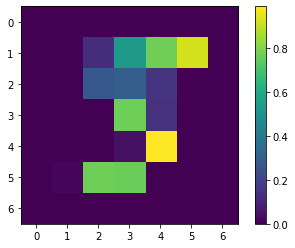

In [119]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [120]:
np.shape(x_train)

(10000, 7, 7, 1)

In [128]:
model = models.Sequential()


model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(7, 7, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [129]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 6, 6, 16)          80        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 32)          2080      
_________________________________________________________________
flatten_22 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_43 (Dense)             (None, 10)                330       
Total params: 6,618
Trainable params: 6,618
Non-trainable params: 0
____________________________________________________

In [130]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 1s 113us/sample - loss: 1.3956 - accuracy: 0.5633
Epoch 2/5
10000/10000 [==============================] - 1s 82us/sample - loss: 0.7444 - accuracy: 0.7612
Epoch 3/5
10000/10000 [==============================] - 1s 83us/sample - loss: 0.6270 - accuracy: 0.8005
Epoch 4/5
10000/10000 [==============================] - 1s 86us/sample - loss: 0.5612 - accuracy: 0.8236
Epoch 5/5
10000/10000 [==============================] - 1s 80us/sample - loss: 0.5193 - accuracy: 0.8385


In [131]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

1000/1000 - 0s - loss: 0.6542 - accuracy: 0.8010


## Make Custom Image Splitter

In [10]:
def splitAndConcat(x, filter_size):
    slice_set = []
    width = x.get_shape()[1]
    height = x.get_shape()[2]
    num_x = width - filter_size + 1
    num_y = height - filter_size + 1
    num_z = x.get_shape()[3]
    for i in range(num_x):
        for j in range(num_y):
            slice_set.append(tf.slice(x, [0, i, j, 0], [-1, filter_size, filter_size, -1]))
    
    stack_set = tf.stack(slice_set, axis=1)
    stack_reshape = tf.reshape(stack_set, shape=[-1, filter_size, filter_size, num_z])
    return stack_reshape

def constant_gen(x):
    return tf.fill([tf.shape(x)[0], 1], 1)

## Make Quantum Convolution Layer

In [93]:
class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth):
        super().__init__(QConv)
        self.filter_size = filter_size
        self.depth = depth
        self.QCNN_layer_gen()
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit])

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _QConv(self, grid_size, qubits, params):    
        """for i, qubit in enumerate(qubits):
            yield cirq.X(qubit)**params[3*i]
            yield cirq.Y(qubit)**params[3*i+1]
            yield cirq.Z(qubit)**params[3*i+2]"""
        for i in range(grid_size):
            for j in range(grid_size//2):
                # yield cirq.CNOT( qubits[grid_size*i + 2*j+1], qubits[grid_size*i + 2*j])
                yield cirq.XX(qubits[grid_size*i + 2*j+1], qubits[grid_size*i + 2*j])**params[3*i]
                yield cirq.YY(qubits[grid_size*i + 2*j+1], qubits[grid_size*i + 2*j])**params[3*i+1]
                yield cirq.ZZ(qubits[grid_size*i + 2*j+1], qubits[grid_size*i + 2*j])**params[3*i+2]
        for i in range(0, grid_size, 2):
            for j in range(grid_size//2):
                yield cirq.XX(
                    qubits[2*grid_size*j + i + grid_size], qubits[2*grid_size*j + i]
                )**params[3*(grid_size+i)]
                yield cirq.YY(
                    qubits[2*grid_size*j + i + grid_size], qubits[2*grid_size*j + i]
                )**params[3*(grid_size+i)+1]
                yield cirq.ZZ(
                    qubits[2*grid_size*j + i + grid_size], qubits[2*grid_size*j + i]
                )**params[3*(grid_size+i)+2]
                
    def QCNN_layer_gen(self):
        cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)
        QCNN_circuit = cirq.Circuit()

        size_set = []
        next_size = self.filter_size
        while(True):
            if next_size == 1:
                break
            size_set.append(next_size)
            next_size //= 2
        area_set = [size*size for size in size_set]
        input_params = [sympy.symbols('a%d' %i) for i in range(self.filter_size*self.filter_size)]
        learning_params = [sympy.symbols('b%d' %i) for i in range(3*sum(area_set))]
        params = input_params + learning_params

        input_circuit = cirq.Circuit()
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))

        for i, next_size in enumerate(size_set):
            next_qubits = self._next_qubit_set(self.filter_size, next_size, cirq_qubits)
            next_params = learning_params[3*(sum(area_set[:i])):3*(sum(area_set[:i])+area_set[i])]
            QCNN_circuit.append(self._QConv(next_size, next_qubits, next_params))

        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)

        self.circuit = full_circuit
        self.params = params
        self.op = cirq.Z(cirq_qubits[0])
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1
        
        self.kernel = self.add_weight(name="kenel", 
                                      shape=[self.depth, 
                                             self.channel, 
                                             4*(self.filter_size*self.filter_size-1)])
        
    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # 필터 크기로 이미지 자르기, 모으기
        slice_set = []
        for i in range(self.num_x):
            for j in range(self.num_y):
                slice_set.append(
                    tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1]))
        stack_set = tf.stack(slice_set, axis=1) 
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        
        # total input citcuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(stack_set)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        
        tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        
        outputs = []
        for i in range(self.depth):
            controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
            outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
            # shape: [N, num_x, num_y]
        output_tensor = tf.stack(outputs, axis=3)
        return output_tensor
          
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, 4*(filter_size*filter_size-1)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, filter_size^2 + 4*(filter_size*filter_size-1)]
        QCNN_output = tfq.layers.Expectation()(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
        return tf.math.reduce_sum(QCNN_output, 3)
        

In [98]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]
main_input = tf.keras.layers.Input(shape=(width, height, 1))
QConv1 = QConv(filter_size=2, depth=4)(main_input)
# pool1 = layers.MaxPooling2D((2, 2))(QConv1)
conv1_flat = layers.Flatten()(QConv1)
fc1 = layers.Dense(64, activation='relu')(conv1_flat)
fc2 = layers.Dense(10, activation='softmax')(fc1)
model = tf.keras.Model(inputs=[main_input], outputs=[fc2])

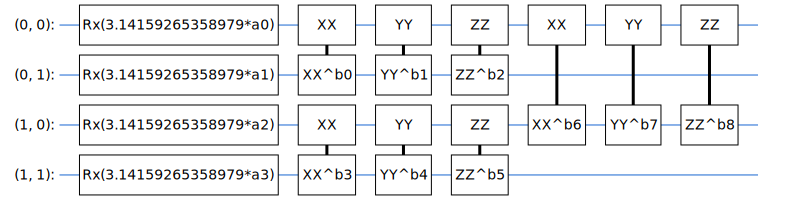

In [99]:
SVGCircuit(QConv(filter_size=2, depth=4).circuit)

In [100]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 7, 7, 1)]         0         
_________________________________________________________________
q_conv_36 (QConv)            (None, 6, 6, 4)           48        
_________________________________________________________________
flatten_19 (Flatten)         (None, 144)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                9280      
_________________________________________________________________
dense_37 (Dense)             (None, 10)                650       
Total params: 9,978
Trainable params: 9,978
Non-trainable params: 0
_________________________________________________________________


In [101]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

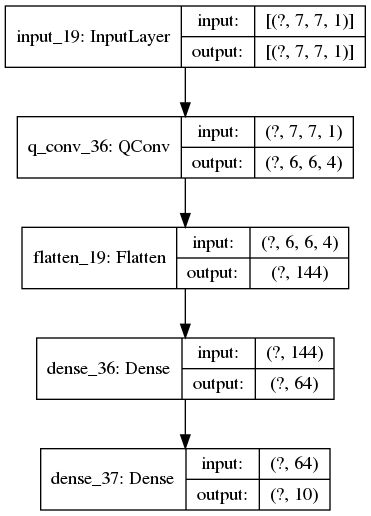

In [102]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [103]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5,batch_size=10)

Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 1019s 102ms/sample - loss: 0.8830 - accuracy: 0.7176
Epoch 2/5
 5710/10000 [================>.............] - ETA: 7:17 - loss: 0.6380 - accuracy: 0.7961

KeyboardInterrupt: 

In [28]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [104]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

1000/1000 - 7s - loss: 0.6953 - accuracy: 0.7790


In [105]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 7, 7, 1)]         0         
_________________________________________________________________
q_conv_36 (QConv)            (None, 6, 6, 4)           48        
_________________________________________________________________
flatten_19 (Flatten)         (None, 144)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                9280      
_________________________________________________________________
dense_37 (Dense)             (None, 10)                650       
Total params: 9,978
Trainable params: 9,978
Non-trainable params: 0
_________________________________________________________________


In [106]:
model_lookup = tf.keras.Model(inputs=[main_input], outputs=[QConv1])

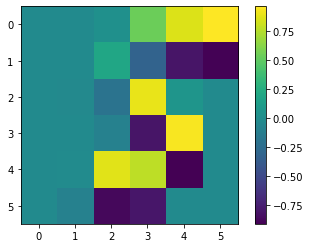

In [115]:
plt.imshow(model_lookup(x_train[0:2])[0,:,:,3])
plt.colorbar()


In [28]:
filter_size = 2
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

main_input = tf.keras.layers.Input(shape=(width, height, 1))
main_input_reform = tf.keras.layers.Lambda(splitAndConcat, arguments={"filter_size":filter_size})(main_input)
main_input_flatten = tf.keras.layers.Flatten()(main_input_reform)

# 학습 가능한 parameter set들, input은 항상 1로 고정해야됨
controller_input = tf.keras.layers.Lambda(constant_gen)(main_input_reform)
controller = tf.keras.layers.Dense(4*(filter_size*filter_size-1), use_bias=False)(controller_input)

QCNN_input = tf.keras.layers.concatenate([main_input_flatten, controller])


def input_repeater(x):
    return tf.tile(x, tf.constant([36], tf.int32))

circuit_inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
circuit_dup = tf.keras.layers.Lambda(input_repeater)(circuit_inputs)

QCNN_layer, QCNN_circuit, QCNN_params, QCNN_op = QCNN_layer_gen(filter_size)

QCNN_output_Flatten = SplitBackpropQ(QCNN_params, [], [], QCNN_op)([circuit_dup, QCNN_input])

QCNN_output = tf.keras.layers.Lambda(reshapeQCNNoutput ,
                                     arguments={"filter_size":filter_size,
                                               "width": width,
                                               "height": height})(QCNN_output_Flatten)


In [29]:
test_image = model(x_train[0:2], tfq.convert_to_tensor([QCNN_circuit]*len(x_train[0:2])))

AssertionError: Could not compute output Tensor("lambda_11/Identity:0", shape=(None, 6, 6, 1), dtype=float32)

In [62]:

tf.reshape((tf.tile([tfq.convert_to_tensor([cirq.Circuit()])], 
                         [2, 1])), shape=[-1])

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'\n\x0e\n\x0ctfq_gate_set\x12\x02\x08\x01',
       b'\n\x0e\n\x0ctfq_gate_set\x12\x02\x08\x01'], dtype=object)>

In [56]:
[tfq.convert_to_tensor([cirq.Circuit()])]

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'\n\x0e\n\x0ctfq_gate_set\x12\x02\x08\x01'], dtype=object)>]

In [58]:
tfq.convert_to_tensor([cirq.Circuit()])

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'\n\x0e\n\x0ctfq_gate_set\x12\x02\x08\x01'], dtype=object)>

In [ ]:
aaa = tf.constant([])